File created by Jinghao Chen (jinghc2@uci.edu).

Make sure file "gfp.pkl" is in the directory.

In [11]:
import pickle

In [12]:
pickle_in = open("gfp.pkl","rb")
gfp = pickle.load(pickle_in)

Check the first 5 reads from the bin #0.

In [13]:
gfp[0][:5]

['AATTAATGTGAGTTAGCTCACTCATTAGGCCCCCCAGGGTTTACACTTTTTGCTACCGTCTCGTATGTTGTTTGC',
 'AATTAAGTAGAGATCGCTCACTCATTAGGCACCCAAGCCGTTACATTTTATGCTTCAGGCCCGTACGCTGTGTGT',
 'GCTTAATGGGAGTGAGCTCACTCATTAGGCACCCCAGTCTTTAGACTTTATGCTTCCGGCTCGTATCTTGCGTGG',
 'GCCCACTCTGAGTTAGCTCAACCACTATGCACCCCAGGCTCTACGCTATTTGATTCCGGCCTGATTGTTGTGTGA',
 'AATTAATGTGAGTTAGCTCACTCATTTGGCAACCCAGTCTTTACCCTTTATGCTTCCGACTCGTATGTTGTTTGG']

In [16]:
len(gfp[0][0])

75

In [ ]:
import numpy as np
np.random.seed(0)

In [26]:
sum([len(gfp[i]) for i in range(1,10)])

46054

In [27]:
51853-len(gfp[0])

46054

In [58]:
data = []

for k in range(1,10):
    for sq in gfp[k]:
        l = []
        for bp in sq[-74:-48]:
            if bp == 'A':
                l += [1,0,0,0]
            elif bp == 'C':
                l += [0,1,0,0]
            elif bp == 'G':
                l += [0,0,1,0]
            elif bp == 'T':
                l += [0,0,0,1]
            else:
                print('error')
                break
        l.append(k)
        l.append(np.heaviside(k-5,-1))
        data.append(l)
        
data = np.array(data)
data = data.astype(np.float64)

In [59]:
data.shape

(46054, 106)

In [65]:
np.unique(data[:,-1])>-1

array([False,  True,  True])

In [61]:
1!=2

True

Import packages for ml model:

In [14]:
from __future__ import division

import torch

import sys
sys.path.append('code')

import mltools as ml # make sure this is installed

import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots

In [62]:
X, Y = data[:,:-2], data[:,-1]   # get features & target
X,Y  = ml.shuffleData(X,Y)       # reorder randomly rather than by class label
X,_  = ml.transforms.rescale(X)  # rescale to improve numerical stability, speed convergence

XA, YA = X[Y>-1,:], Y[Y>-1]        # Dataset A: class 0 vs class 1
# XB, YB = X[Y>0,:], Y[Y>0]        # Dataset B: class 1 vs class 2

In [63]:
X

array([[-2.64726247, -0.19343166,  5.19907993, ..., -0.1892859 ,
        -0.19886364, -0.22048179],
       [ 0.37774872, -0.19343166, -0.19234172, ..., -0.1892859 ,
        -0.19886364, -0.22048179],
       [ 0.37774872, -0.19343166, -0.19234172, ..., -0.1892859 ,
        -0.19886364, -0.22048179],
       ...,
       [ 0.37774872, -0.19343166, -0.19234172, ..., -0.1892859 ,
        -0.19886364, -0.22048179],
       [-2.64726247, -0.19343166, -0.19234172, ..., -0.1892859 ,
        -0.19886364, -0.22048179],
       [ 0.37774872, -0.19343166, -0.19234172, ..., -0.1892859 ,
        -0.19886364, -0.22048179]])

In [66]:
XA.shape

(40676, 104)

In [53]:
Y

array([9., 7., 3., ..., 8., 7., 1.])

In [52]:
Y.shape

(46054,)

In [68]:
class logisticClassify2(ml.classifier):     # trivial shell class to contain whatever we want
    def predict(self,X): pass       # we will replace the shell later as we extend the class
    def train(self,X): pass

In [55]:
def myPredict(self,X):
    '''Predict model on data X; return nparray of class predictions'''
    R = torch.Tensor(X) @ self.theta[1:] + self.theta[0]  # compute linear response
    Y01 = 1*(R>0)                   # binary classification threshold; convert to integers
    Y = self.classes[Y01]           # use lookup to convert back to class values if given
    return Y                        # NOTE: returns as numpy, not torch! (b/c classes is a nparray)
                                    # (This is necessary for mltools plot to work)

In [69]:
# Create a shell classifier
class logisticClassify2(ml.classifier):
    predict = myPredict              #
    train = None                     # this function will be implemented later

In [57]:
from IPython import display

def myTrain(self,X,Y, initStep=1.,stopTol=1e-4,stopEpochs=5000,alpha=0,plot=None):
    """ Train the logistic regression using stochastic gradient descent """
    M,N = X.shape;                     # initialize the model if necessary:
    self.classes = np.unique(Y);       # Y may have two classes, any values
    X1 = np.hstack((np.ones((M,1)),X)) # X1 is X, but with an extra column of ones
    Y01 = ml.toIndex(Y,self.classes);  # Y01 is Y, but with canonical values 0 or 1
    
    # if the shape of initial theta is wrong, randomly generate a correct one
    if len(self.theta)!=N+1: self.theta=torch.randn((N+1,));
        
    # init loop variables:
    epoch=0; done=False; Jnll=[]; J01=[];            # initialize loop variables
    myrate = lambda epoch: initStep*2.0/(2.0+epoch)  # step size as a f'n of epoch

    opt = torch.optim.SGD([self.theta], initStep)
    sched = torch.optim.lr_scheduler.LambdaLR(opt, myrate)
    
    while not done:
        # Do an SGD pass through the entire data set:
        Jnll.append(0.)
        for i in np.random.permutation(M):
            # Compute predictions and loss for *just* data X[i]:
            ri = torch.tensor(X1[i],dtype=torch.float32) @ self.theta;
            si = 1/(1+torch.exp(-ri)); # TODO: logistic (probability) prediction of the class
            Ji = -Y01[i]*torch.log(si)-(1-Y01[i])*torch.log(1-si); # TODO: torch.Tensor shape [] (scalar)
            Jnll[-1] += float(Ji)/M             # find running average of surrogate loss
            opt.zero_grad()                     # Ji should be a torch.tensor of shape []
            Ji.backward()
            opt.step()
        sched.step()
        

        epoch += 1
        J01.append( self.err(X,Y) )  # evaluate the current actual error rate 

        display.clear_output(wait=True); plt.figure(figsize=(10,5));
        # plt.subplot(1,2,1); 
        plt.cla(); plt.plot(Jnll,'b-',J01,'r-');    # plot losses
        # if N==2: plt.subplot(1,2,2); plt.cla(); self.plotBoundary(X,Y); # & predictor if 2D
        plt.show(); plt.pause(.01);                    # let OS draw the plot

        ## For debugging: you may want to print current parameters & losses
        # print(self.theta, ' => ', Jnll, ' / ', J01[-1] )
        # input()   # pause for keystroke

        # TODO check stopping criteria: exit if exceeded # of epochs ( > stopEpochs)
        done = epoch > stopEpochs or abs(Jnll[-1]) < stopTol;   # or if Jnll not changing between epochs ( < stopTol )


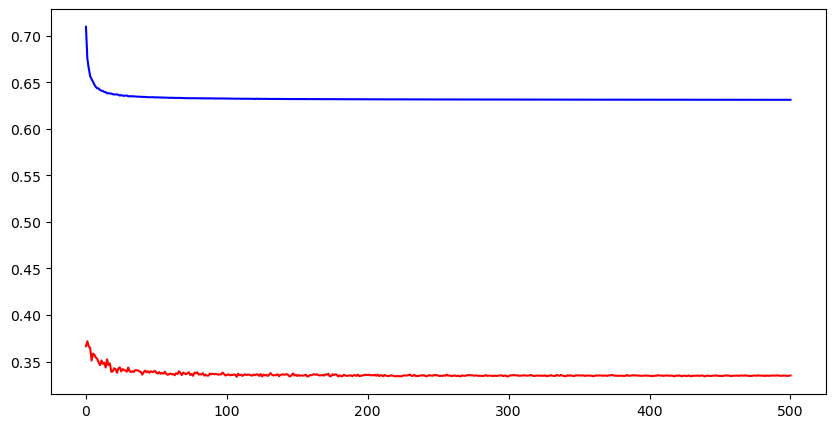

In [71]:
# Update our shell classifier definition
class logisticClassify2(ml.classifier):
    predict = myPredict              # Now all parts are implemented
    train = myTrain

learnerA = logisticClassify2()
learnerA.classes = np.unique(YA)
learnerA.theta = torch.tensor([1.]*105,requires_grad = True);
learnerA.train(XA,YA,initStep=1e-1,stopEpochs=500,stopTol=1e-5);